# Kitchenware Classification

https://www.kaggle.com/competitions/kitchenware-classification

In this competition we need to classify images of different kitchenware items into 6 classes:
* cups
* glasses
* plates
* spoons
* forks
* knives

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from PIL import Image
from sklearn.model_selection import train_test_split
from os import path
import datetime

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.xception import preprocess_input as preprocess_tf
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_caffee

2022-12-21 09:36:35.003130: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [4]:
SEED = 41

# 1. Read the data

In [5]:
data_path = '.'
image_path = path.join(data_path, 'images')
train_path = path.join(data_path, 'train.csv')
test_path = path.join(data_path, 'test.csv')
submission_path = path.join(data_path, 'submission.csv')

In [6]:
# let's take a look, how many images do we have in the images folder
!ls {image_path} | wc -l

9367


In [7]:
# read the train data
df_train = pd.read_csv(train_path)
df_train.columns = df_train.columns.str.lower()
df_train['file_name'] = df_train['id'].map('{:04}.jpg'.format)
print(df_train.shape)
df_train.head()

(5559, 3)


,id,label,file_name
0,560,glass,0560.jpg
1,4675,cup,4675.jpg
2,875,glass,0875.jpg
3,4436,spoon,4436.jpg
4,8265,plate,8265.jpg


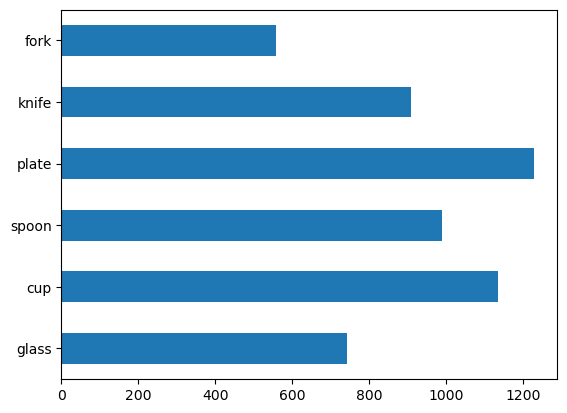

In [8]:
# let's take a look at class balance
df_train.label.value_counts(sort=False).plot(kind='barh');

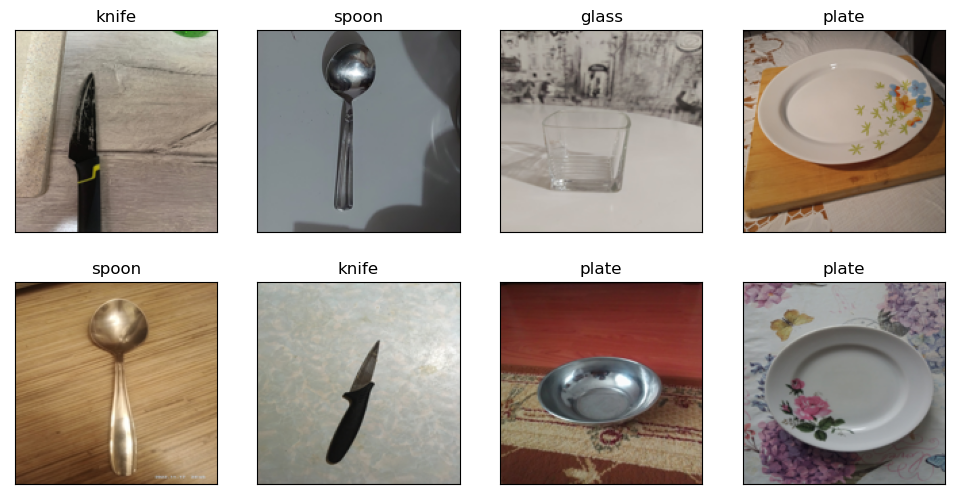

In [9]:
# show some images
fig, axes = plt.subplots(2,4,figsize=(12,6))
df_subsample, _ = train_test_split(df_train, train_size=2000, random_state=SEED)
for i, ax in enumerate(axes.reshape(-1)):
    row = df_subsample.iloc[i] 
    image_file = path.join(image_path, row['file_name'])
    image = Image.open(image_file).resize((150,150))
    ax.imshow(image)
    ax.set_title(row['label'])
    ax.set_xticks([])
    ax.set_yticks([])

# 2. Baseline

In [10]:
# split the data into the train and validation
df_t, df_v = train_test_split(df_subsample, test_size=0.2, random_state=SEED)

In [11]:
def make_model(model_class, 
              target_size=(150,150), 
              learning_rate=0.01,  
              size_inner=None,
              dropout_rate=None):
    
    input_shape = target_size+(3,) # (150,150,3)
    
    base_model = model_class(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False
          
    model = keras.Sequential()
    
    model.add(keras.Input(shape=input_shape))
    model.add(base_model)
    model.add(keras.layers.GlobalAveragePooling2D())
    
    if size_inner is not None:
        model.add(keras.layers.Dense(size_inner, activation='relu'))
        
    if dropout_rate is not None:
        model.add(keras.layers.Dropout(dropout_rate))
        
    model.add(keras.layers.Dense(6))
    
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    
    return model 

In [12]:
def fit_model(model, comment="", target_size=(150,150), epochs=8):
    
    model_name = model.get_layer(index=0).get_config()['name']
    
    start_date = datetime.datetime.now()
    print(start_date.strftime('%H:%M:%S'))
    print(f"[MODEL] {model_name} {comment}...")
    
    if model_name == 'xception' or model_name == 'inception_v3':
        preprocess = preprocess_tf
    else:
        preprocess = preprocess_caffee
    
   
    train_gen = ImageDataGenerator(preprocessing_function=preprocess)

    train_ds = train_gen.flow_from_dataframe(df_t, 
                                         directory=image_path, 
                                         x_col='file_name', 
                                         y_col='label', 
                                         target_size=target_size,
                                         batch_size=32,
                                         shuffle=True)
    
    val_ds = train_gen.flow_from_dataframe(df_v, 
                                       directory=image_path, 
                                       x_col='file_name', 
                                       y_col='label', 
                                       target_size=target_size,
                                       batch_size=32,
                                       shuffle=False)
    
    history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=1)
    
    time_delta = (datetime.datetime.now() - start_date).seconds
    print(f'[RESULT] {time_delta} seconds, ' 
              f'val_accuracy: {np.mean(history.history["val_accuracy"]):.3f}' 
              f' +- {np.std(history.history["val_accuracy"][-5:]):.2f}')
    print()
    
    return history
    

In [14]:
# fit keras models
results = []
for model_class in [Xception, 
                    VGG16, 
                    VGG19, 
                    ResNet50, 
                    InceptionV3, 
                    EfficientNetB7]:
    
    model = make_model(model_class)
    history = fit_model(model)
    results.append([model_class.__class__.__name__, history])

2022-12-20 20:13:49.373229: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 20:13:49.379402: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 20:13:49.380014: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-20 20:13:49.380917: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

20:13:51
[MODEL] xception ...
Found 1600 validated image filenames belonging to 6 classes.
Found 400 validated image filenames belonging to 6 classes.
Epoch 1/8


2022-12-20 20:13:55.345559: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-20 20:13:55.959518: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 20:13:55.960403: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 20:13:55.960436: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-20 20:13:55.961403: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-20 20:13:55.961468: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


50/50 [==============================] - 28s 469ms/step - loss: 0.7038 - accuracy: 0.8081 - val_loss: 0.7593 - val_accuracy: 0.8175
Epoch 2/8
50/50 [==============================] - 22s 440ms/step - loss: 0.2346 - accuracy: 0.9306 - val_loss: 0.6649 - val_accuracy: 0.8375
Epoch 3/8
50/50 [==============================] - 22s 443ms/step - loss: 0.1364 - accuracy: 0.9525 - val_loss: 0.7921 - val_accuracy: 0.8250
Epoch 4/8
50/50 [==============================] - 22s 443ms/step - loss: 0.0509 - accuracy: 0.9837 - val_loss: 0.7702 - val_accuracy: 0.8425
Epoch 5/8
50/50 [==============================] - 22s 442ms/step - loss: 0.0233 - accuracy: 0.9931 - val_loss: 0.6607 - val_accuracy: 0.8525
Epoch 6/8
50/50 [==============================] - 22s 444ms/step - loss: 0.0092 - accuracy: 0.9981 - val_loss: 0.6995 - val_accuracy: 0.8375
Epoch 7/8
50/50 [==============================] - 22s 443ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.6791 - val_accuracy: 0.8550
Epoch 8/8
50/50 

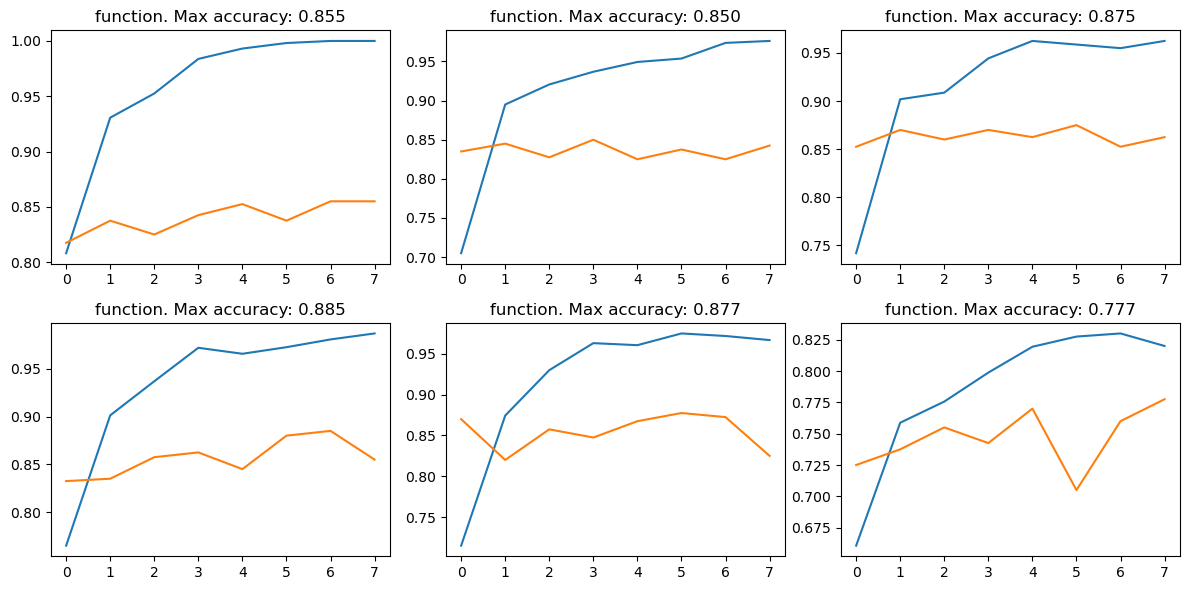

In [15]:
# compare baseline models
fig, axes = plt.subplots(2,3, figsize=(12,6))
for i, ax in enumerate(axes.reshape(-1)):
    model_name = results[i][0]
    history = results[i][1]
    ax.plot(history.history['accuracy'], label='train')
    ax.plot(history.history['val_accuracy'], label='test')
    ax.set_title(f'{model_name}. Max accuracy: {max(history.history["val_accuracy"]):.3f}')
plt.tight_layout()

For the next steps I choose the __InceptionV3__ model because:
* it shows best accuracy
* it's more stable than other models

# 3. Adjusting learning rate

In [16]:
results_lr = []
for lr in [0.0001, 0.001, 0.01, 0.1]:
   
    model = make_model(InceptionV3, learning_rate=lr)
    history = fit_model(model, f'learning_rate={lr}')

    results_lr.append([lr,history])

20:33:00
[MODEL] inception_v3 learning_rate=0.0001...
Found 1600 validated image filenames belonging to 6 classes.
Found 400 validated image filenames belonging to 6 classes.
Epoch 1/8
50/50 [==============================] - 27s 474ms/step - loss: 2.2652 - accuracy: 0.2994 - val_loss: 1.6351 - val_accuracy: 0.4175
Epoch 2/8
50/50 [==============================] - 22s 445ms/step - loss: 1.2144 - accuracy: 0.5531 - val_loss: 1.0650 - val_accuracy: 0.6425
Epoch 3/8
50/50 [==============================] - 22s 442ms/step - loss: 0.8255 - accuracy: 0.7119 - val_loss: 0.8374 - val_accuracy: 0.7325
Epoch 4/8
50/50 [==============================] - 22s 440ms/step - loss: 0.6500 - accuracy: 0.7763 - val_loss: 0.7333 - val_accuracy: 0.7675
Epoch 5/8
50/50 [==============================] - 22s 444ms/step - loss: 0.5585 - accuracy: 0.8106 - val_loss: 0.6718 - val_accuracy: 0.7875
Epoch 6/8
50/50 [==============================] - 22s 442ms/step - loss: 0.4960 - accuracy: 0.8313 - val_loss: 0.6

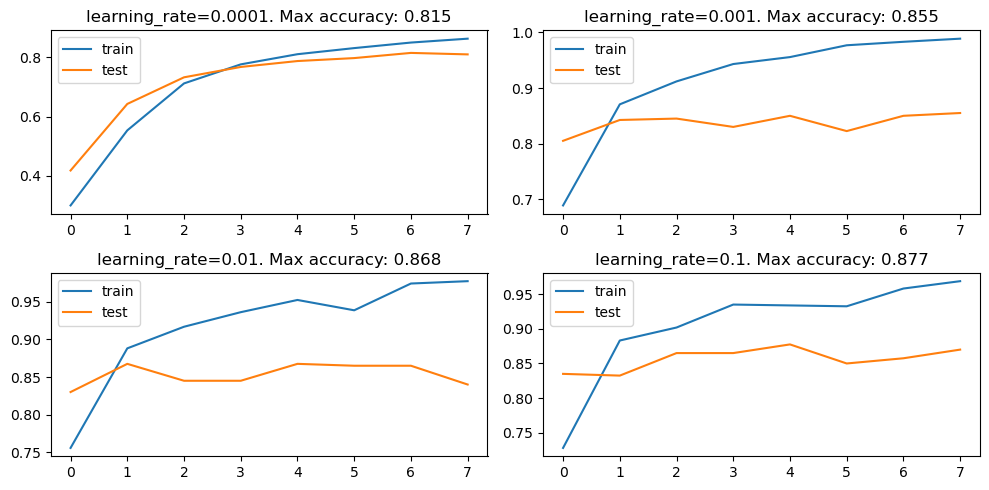

In [19]:
# choose learning rate
fig, axes = plt.subplots(2,2, figsize=(10,5))
for i, ax in enumerate(axes.reshape(-1)):
    learning_rate = results_lr[i][0]
    history = results_lr[i][1]
    ax.plot(history.history['accuracy'], label='train')
    ax.plot(history.history['val_accuracy'], label='test')
    ax.set_title(f'learning_rate={learning_rate}. Max accuracy: {max(history.history["val_accuracy"]):.3f}')
    ax.legend()
plt.tight_layout()

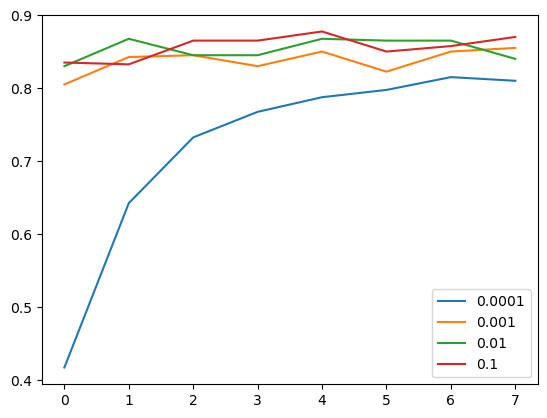

In [18]:
for learning_rate, history in results_lr:
    plt.plot(history.history['val_accuracy'], label=learning_rate)
plt.legend();

In [17]:
best_learning_rate = 0.01

# 4. Adding more layers

* Adding one inner dense layer
* Experimenting with different sizes of inner layers

In [23]:
results_sizes = []
for size in [25, 50, 100, 250, 500, 1000]:
    
    model = make_model(InceptionV3, learning_rate=best_learning_rate, size_inner=size)
    history = fit_model(model, f'size_inner={size}')
    
    results_sizes.append([size,history])

20:52:06
[MODEL] inception_v3 size_inner=25...
Found 1600 validated image filenames belonging to 6 classes.
Found 400 validated image filenames belonging to 6 classes.
Epoch 1/8
50/50 [==============================] - 27s 474ms/step - loss: 1.2218 - accuracy: 0.6494 - val_loss: 0.7294 - val_accuracy: 0.7875
Epoch 2/8
50/50 [==============================] - 22s 442ms/step - loss: 0.4581 - accuracy: 0.8375 - val_loss: 0.5174 - val_accuracy: 0.8650
Epoch 3/8
50/50 [==============================] - 22s 444ms/step - loss: 0.3010 - accuracy: 0.8925 - val_loss: 0.5231 - val_accuracy: 0.8550
Epoch 4/8
50/50 [==============================] - 22s 441ms/step - loss: 0.2273 - accuracy: 0.9269 - val_loss: 0.5440 - val_accuracy: 0.8450
Epoch 5/8
50/50 [==============================] - 22s 444ms/step - loss: 0.1452 - accuracy: 0.9513 - val_loss: 0.5547 - val_accuracy: 0.8500
Epoch 6/8
50/50 [==============================] - 22s 444ms/step - loss: 0.1528 - accuracy: 0.9419 - val_loss: 0.4986 - v

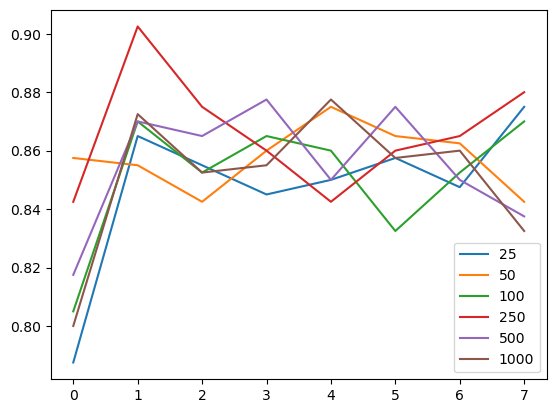

In [25]:
for size, history in results_sizes:
    plt.plot(history.history['val_accuracy'], label=size)
plt.legend();

In [16]:
best_inner_size = 250

# 5. Dropout
* Regularizing by freezing a part of the network
* Adding dropout to our model
* Experimenting with different values

In [30]:
results_drop = []
for rate in [0.1, 0.2, 0.4, 0.6]:
    
    model = make_model(InceptionV3, learning_rate=best_learning_rate, size_inner=best_inner_size, dropout_rate=rate)
    history = fit_model(model, f'dropout_rate={rate}', epochs=20)
    
    results_drop.append([rate,history])

21:13:32
[MODEL] inception_v3 dropout_rate=0.1...
Found 1600 validated image filenames belonging to 6 classes.
Found 400 validated image filenames belonging to 6 classes.
Epoch 1/20
50/50 [==============================] - 27s 471ms/step - loss: 5.7488 - accuracy: 0.7188 - val_loss: 0.5237 - val_accuracy: 0.8425
Epoch 2/20
50/50 [==============================] - 22s 441ms/step - loss: 0.3795 - accuracy: 0.8637 - val_loss: 0.3990 - val_accuracy: 0.8700
Epoch 3/20
50/50 [==============================] - 22s 441ms/step - loss: 0.3013 - accuracy: 0.8875 - val_loss: 0.4314 - val_accuracy: 0.8725
Epoch 4/20
50/50 [==============================] - 22s 443ms/step - loss: 0.2198 - accuracy: 0.9194 - val_loss: 0.3808 - val_accuracy: 0.8600
Epoch 5/20
50/50 [==============================] - 22s 440ms/step - loss: 0.2030 - accuracy: 0.9162 - val_loss: 0.3692 - val_accuracy: 0.8800
Epoch 6/20
50/50 [==============================] - 22s 441ms/step - loss: 0.1417 - accuracy: 0.9506 - val_loss: 0

Epoch 14/20
50/50 [==============================] - 22s 442ms/step - loss: 0.3433 - accuracy: 0.8637 - val_loss: 0.6029 - val_accuracy: 0.8675
Epoch 15/20
50/50 [==============================] - 22s 443ms/step - loss: 0.3298 - accuracy: 0.8788 - val_loss: 0.5360 - val_accuracy: 0.8675
Epoch 16/20
50/50 [==============================] - 22s 441ms/step - loss: 0.2859 - accuracy: 0.8950 - val_loss: 0.6626 - val_accuracy: 0.8575
Epoch 17/20
50/50 [==============================] - 22s 444ms/step - loss: 0.2970 - accuracy: 0.8863 - val_loss: 0.5309 - val_accuracy: 0.8525
Epoch 18/20
50/50 [==============================] - 22s 444ms/step - loss: 0.3488 - accuracy: 0.8712 - val_loss: 0.6315 - val_accuracy: 0.8475
Epoch 19/20
50/50 [==============================] - 22s 443ms/step - loss: 0.4050 - accuracy: 0.8606 - val_loss: 0.5758 - val_accuracy: 0.8650
Epoch 20/20
50/50 [==============================] - 22s 442ms/step - loss: 0.3362 - accuracy: 0.8712 - val_loss: 0.6563 - val_accuracy:

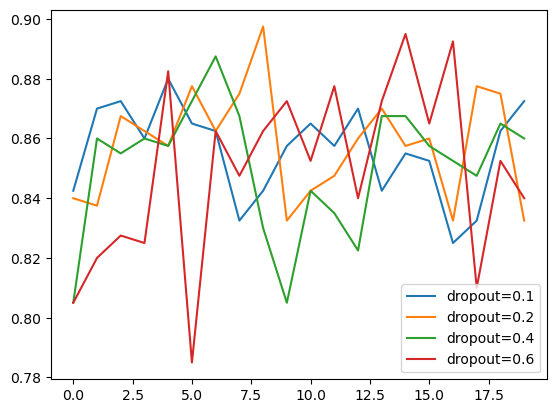

In [31]:
for rate, history in results_drop:
    plt.plot(history.history['val_accuracy'], label=f'dropout={rate}')
plt.legend();

In [15]:
best_dropout_rate = 0.2

# 6 Target size

In [35]:
results_ts = []
for target_size in [(100,100), (150,150), (224,224), (299,299)]:
    
    model = make_model(InceptionV3, 
                       learning_rate=best_learning_rate, 
                       size_inner=best_inner_size, 
                       dropout_rate=best_dropout_rate,
                       target_size=target_size)
    
    history = fit_model(model, f'target_size={target_size}', target_size=target_size)
    
    results_ts.append([target_size,history])

21:47:47
[MODEL] inception_v3 target_size=(100, 100)...
Found 1600 validated image filenames belonging to 6 classes.
Found 400 validated image filenames belonging to 6 classes.
Epoch 1/8
50/50 [==============================] - 28s 467ms/step - loss: 6.0944 - accuracy: 0.4956 - val_loss: 0.7864 - val_accuracy: 0.7375
Epoch 2/8
50/50 [==============================] - 22s 434ms/step - loss: 0.7701 - accuracy: 0.7113 - val_loss: 0.7139 - val_accuracy: 0.7625
Epoch 3/8
50/50 [==============================] - 22s 435ms/step - loss: 0.6160 - accuracy: 0.7738 - val_loss: 0.6525 - val_accuracy: 0.7750
Epoch 4/8
50/50 [==============================] - 22s 436ms/step - loss: 0.5202 - accuracy: 0.7962 - val_loss: 0.7089 - val_accuracy: 0.7650
Epoch 5/8
50/50 [==============================] - 22s 433ms/step - loss: 0.5396 - accuracy: 0.8006 - val_loss: 0.7435 - val_accuracy: 0.7400
Epoch 6/8
50/50 [==============================] - 22s 434ms/step - loss: 0.4956 - accuracy: 0.8175 - val_loss: 0

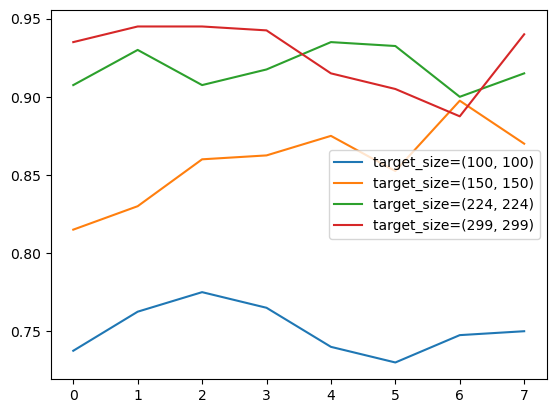

In [36]:
for target_size, history in results_ts:
    plt.plot(history.history['val_accuracy'], label=f'target_size={target_size}')
plt.legend();

In [14]:
best_target_size=(299,299)

# 7 Train the full model with best params

In [45]:
# Train model on the full data
train_gen = ImageDataGenerator(preprocessing_function=preprocess_tf,
                              horizontal_flip=True)

train_ds = train_gen.flow_from_dataframe(df_train, 
                                         directory=image_path, 
                                         x_col='file_name', 
                                         y_col='label', 
                                         target_size=best_target_size,
                                         batch_size=32,
                                         shuffle=True)

Found 5559 validated image filenames belonging to 6 classes.


In [46]:
model = make_model(InceptionV3, 
                       learning_rate=best_learning_rate, 
                       size_inner=best_inner_size, 
                       dropout_rate=best_dropout_rate,
                       target_size=best_target_size)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 250)               512250    
                                                                 
 dropout_2 (Dropout)         (None, 250)               0         
                                                                 
 dense_5 (Dense)             (None, 6)                 1506      
                                                                 
Total params: 22,316,540
Trainable params: 513,756
Non-trainable params: 21,802,784
____________________________________

In [47]:
checkpoint = keras.callbacks.ModelCheckpoint(
    'inception_v3_{epoch:02d}_{accuracy:.3f}.h5',
    save_best_only=True,
    monitor='accuracy',
    mode='max'
)

In [48]:
history = model.fit(train_ds, epochs=3)
#history = model.fit(train_ds, epochs=3, callbacks=[checkpoint])

Epoch 1/3
174/174 [==============================] - 75s 407ms/step - loss: 0.6605 - accuracy: 0.8690
Epoch 2/3
174/174 [==============================] - 71s 406ms/step - loss: 0.2202 - accuracy: 0.9291
Epoch 3/3
174/174 [==============================] - 71s 407ms/step - loss: 0.2047 - accuracy: 0.9261


In [49]:
# save model to the file
model.save('kitchenware_image_classiffication.h5')

In [ ]:
# save to bentoml
import bentoml
bentoml.keras.save_model("bento_kitchenware_image_classiffication", model, custom_objects={'classes':classes})

# 8. Predictions to Kaggle

In [50]:
df_test = pd.read_csv(test_path)
df_test.columns = df_test.columns.str.lower()
df_test['file_name'] = df_test['id'].map('{:04}.jpg'.format)
print(df_test.shape)
df_test.head()

(3808, 2)


,id,file_name
0,678,0678.jpg
1,3962,3962.jpg
2,9271,9271.jpg
3,5133,5133.jpg
4,8842,8842.jpg


In [51]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_tf)

test_ds = test_gen.flow_from_dataframe(df_test, 
                                         directory=image_path, 
                                         x_col='file_name',  
                                         target_size=best_target_size,
                                         class_mode='input',
                                         shuffle=False,
                                         batch_size=32)

Found 3808 validated image filenames.


In [52]:
y_pred = model.predict(test_ds)

119/119 [==============================] - 53s 438ms/step


In [53]:
classes = np.array(list(train_ds.class_indices.keys()))
classes

array(['cup', 'fork', 'glass', 'knife', 'plate', 'spoon'], dtype='<U5')

In [54]:
predictions = classes[y_pred.argmax(axis=1)]

In [55]:
df_submission = pd.DataFrame()
df_submission['file_name'] = test_ds.filenames
df_submission['label'] = predictions

df_submission['Id'] = df_submission.file_name.str[:-4]

In [56]:
df_submission

,file_name,label,Id
0,0678.jpg,spoon,0678
1,3962.jpg,knife,3962
2,9271.jpg,fork,9271
3,5133.jpg,plate,5133
4,8842.jpg,fork,8842
...,...,...,...
3803,7626.jpg,plate,7626
3804,2052.jpg,cup,2052
3805,8827.jpg,spoon,8827
3806,2299.jpg,fork,2299


In [57]:
df_submission[['Id', 'label']].to_csv('submission.csv', index=False)

In [58]:
!kaggle competitions submit kitchenware-classification -f submission.csv -m 'accuracy: 0.902'

100%|██████████████████████████████████████| 39.0k/39.0k [00:00<00:00, 40.8kB/s]
Successfully submitted to Kitchenware Classification

In [ ]:
# Score on kaggle: 0.94

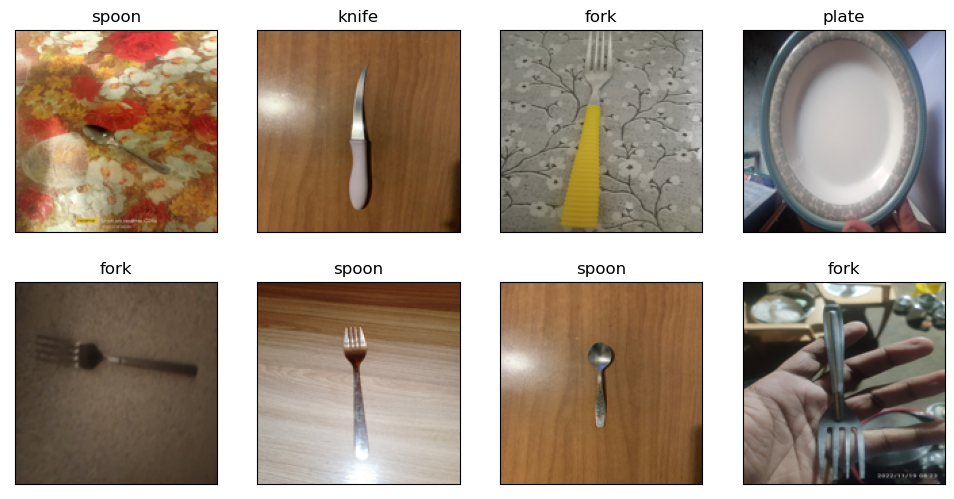

In [59]:
fig, axes = plt.subplots(2,4,figsize=(12,6))
for i, ax in enumerate(axes.reshape(-1)):
    row = df_submission.iloc[i] 
    image_file = path.join(image_path, row['file_name'])
    image = Image.open(image_file).resize((150,150))
    ax.imshow(image)
    ax.set_title(row['label'])
    ax.set_xticks([])
    ax.set_yticks([])